In [1]:
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.models import clone_model

from dm_control import suite
from dm_control import viewer
import time

from matplotlib import pyplot as plt

In [2]:
def convert_observation(obs):
    list1 = [i.tolist() for i in list(obs.values())]
    list2 = np.array([])
    for sublist in list1:
        list2 = np.append(list2, sublist)
    return list2.reshape([1,25])

In [3]:
# parameters and models from : https://arxiv.org/pdf/1801.00690.pdf

 

In [4]:
tf.keras.backend.set_floatx('float64')

class Agent:
    def actor_loss(self,y_true,y_pred):
        return - tf.reduce_mean(y_true)
    
    def __init__(self, action_spec):
        self.memory = {
            "state":np.array([]), 
            "action":np.array([], dtype = int), 
            "reward":np.array([]),
            "new_state":np.array([]), 
            "done":np.array([])
        }
        self.batch_size=64
        self.discount_rate=0.99
        self.tau=0.001
        self.action_dim = len(action_spec.minimum)
        self.action_spec = action_spec
        self.action_bound = 1
        self.input_size = 25
        self.noise = 0
        
        self.critic_opt = tf.optimizers.Adam(1e-4)
        self.actor_opt = tf.optimizers.Adam(1e-4, clipvalue=1)
        

        # create critic model:
        input_obs = tf.keras.Input(shape=self.input_size, name = 'state')
        input_actions = tf.keras.Input(shape=(self.action_dim,), name = 'action')
        h = tf.keras.layers.Dense(400, activation = 'relu')(input_obs)
        tmp1 = tf.keras.layers.Dense(300, activation = 'relu')(h)
        action_abs = tf.keras.layers.Dense(300, activation = 'relu')(input_actions)
        h = tf.keras.layers.Add()([tmp1,action_abs])
        h = tf.keras.layers.Activation('relu')(h)
        pred = tf.keras.layers.Dense(1, activation = 'relu')(h)
        model = tf.keras.Model(inputs=[input_obs, input_actions], outputs=pred)   
        model.compile(loss='mse', optimizer=self.critic_opt)
        self.critic_model = model

        # create actor model:
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(300, input_dim = self.input_size, activation='relu'))
        model.add(tf.keras.layers.Dense(200, activation='relu'))
        model.add(tf.keras.layers.Dense(self.action_dim, activation = "relu"))
        model.compile(loss = self.actor_loss, optimizer=self.actor_opt)
        self.actor_model = model

        # target models:
        self.target_critic_model = clone_model(self.critic_model)
        self.target_actor_model = clone_model(self.actor_model)
 
    def sample_action(self, obs):
        action = self.actor_model.predict(obs)
        action = action + self.noise()
        action = np.clip(action, -1, 1)
        return action
    
    def init_noise(self):
        self.noise = OrnsteinUhlenbeckActionNoise(mu = np.zeros(self.action_dim))
    
    def store_info(self, obs, new_obs, action, reward, done):
        if len(self.memory["state"])>0:
            if self.memory["done"].shape[0]>1e6:
                for key in self.memory.keys():
                    self.memory[key] = self.memory[key][-int(0.9e6):]
            self.memory["state"] = np.vstack((self.memory["state"], obs))
            self.memory["new_state"] = np.vstack((self.memory["new_state"], new_obs))
            self.memory["action"] = np.vstack((self.memory["action"], action))
        else:            
            self.memory["state"] = np.array(obs)
            self.memory["new_state"] = np.array(new_obs)
            self.memory["action"] = np.array(action)
        self.memory["reward"] = np.append(self.memory["reward"], reward)
        self.memory["done"] = np.append(self.memory["done"], done)        
        
        
    def experience_replay(self):
        if self.memory["done"].shape[0]>=self.batch_size:
            # get batch
            idxs = np.random.randint(self.memory["done"].shape[0], size=self.batch_size)
            batch = {
                "state": np.squeeze(self.memory["state"][idxs]), 
                "action": np.squeeze(self.memory["action"][idxs]), 
                "reward": self.memory["reward"][idxs], 
                "new_state": np.squeeze(self.memory["new_state"][idxs]), 
                "done": self.memory["done"][idxs]
            }
            
            # replay:
            target_q = self.target_critic_model({"state":batch["new_state"], 
                                            "action": self.target_actor_model(batch["new_state"])})

            y = batch["reward"].reshape(self.batch_size,1) + np.multiply(target_q, 
                                                                        (self.discount_rate*(1-batch["done"])
                                                                        ).reshape(self.batch_size,1)
                                                                        ) 
            
            # update critic
            with tf.GradientTape() as tape:
                q = self.critic_model({"state": batch["state"], "action": batch["action"]})
                td_error = tf.losses.mean_squared_error(y, q)
            critic_grads = tape.gradient(td_error, self.critic_model.trainable_weights)
            self.critic_opt.apply_gradients(zip(critic_grads, self.critic_model.trainable_weights))
                
            
            # update actor policy
            with tf.GradientTape() as tape:
                actions_pred = self.actor_model(batch["state"])
                q = self.critic_model({"state": batch["state"], "action": actions_pred})
                actor_loss = - tf.reduce_mean(q)
            actor_grads = tape.gradient(actor_loss, self.actor_model.trainable_weights)
            self.actor_opt.apply_gradients(zip(actor_grads, self.actor_model.trainable_weights))
                        
            # update networks
            self.critic_model.set_weights(self.tau * np.array(self.target_critic_model.get_weights()) + \
                                          (1.0-self.tau)*np.array(self.critic_model.get_weights()))
            self.actor_model.set_weights(self.tau * np.array(self.target_actor_model.get_weights()) + \
                                         (1.0-self.tau)*np.array(self.actor_model.get_weights()))


In [5]:
def save_models(agent):
    agent.critic_model.save('critic_model.h5')
    agent.actor_model.save('actor_model.h5')
    agent.target_critic_model.save('target_critic_model.h5')
    agent.target_actor_model.save('target_actor_model.h5')
    
def train_model(env, n_iterations, batch_size, discount_rate):
    scores = np.array([])
    last_rewards = np.array([])
    first_rewards = np.array([])
    action_spec = env.action_spec()
    agent = Agent(action_spec)
    start = time.time()
    for iteration in range(n_iterations):
        agent.init_noise()
        
        if iteration % 25 == 0:
            save_models(agent)
            print("{:10.3f} minutes remaining".format((time.time()-start)/60))

        time_step = env.reset()  
        obs = convert_observation(time_step.observation)

        game_score = 0
        while not time_step.last():       
            # get action:
            action = agent.sample_action(obs)
            # make action:
            time_step = env.step(action[0])
            new_obs = convert_observation(time_step.observation)            
            # update history:
            game_score += time_step.reward 
            agent.store_info(obs, new_obs, action, time_step.reward, 0)
            obs = new_obs
            # experience replay:
            agent.experience_replay()
            if len(first_rewards)==len(last_rewards):
                first_rewards = np.append(first_rewards, time_step.reward)

        new_obs = convert_observation(time_step.observation)   
        agent.store_info(obs, new_obs, action, time_step.reward, 1)
        agent.experience_replay()
        game_score += time_step.reward 
        
        scores = np.append(scores, game_score)
        last_rewards = np.append(last_rewards, time_step.reward)
        print("Iteration: {};   score: {:10.3f}; last_reward: {:10.3f}; first_reward: {:10.3f}".format(
            iteration, game_score, time_step.reward, first_rewards[-1]))

    save_models(agent)
    return scores, last_rewards, first_rewards, agent


In [6]:
n_iterations = 500
env = suite.load(domain_name="swimmer", task_name="swimmer6")
action_spec = env.action_spec()

scores, last_rewards, first_rewards, agent = train_model(env, n_iterations, batch_size=64, discount_rate=0.99)

     0.012 minutes remaining
Iteration: 0;   score:     60.665; last_reward:      0.053; first_reward:      0.064
Iteration: 1;   score:     22.753; last_reward:      0.024; first_reward:      0.021
Iteration: 2;   score:     30.967; last_reward:      0.044; first_reward:      0.025
Iteration: 3;   score:    860.161; last_reward:      0.974; first_reward:      0.899
Iteration: 4;   score:      4.209; last_reward:      0.004; first_reward:      0.004
Iteration: 5;   score:      9.395; last_reward:      0.009; first_reward:      0.010
Iteration: 6;   score:    982.579; last_reward:      1.000; first_reward:      0.653
Iteration: 7;   score:      5.474; last_reward:      0.005; first_reward:      0.006
Iteration: 8;   score:     26.504; last_reward:      0.025; first_reward:      0.034
Iteration: 9;   score:     13.885; last_reward:      0.012; first_reward:      0.011
Iteration: 10;   score:      6.706; last_reward:      0.007; first_reward:      0.006
Iteration: 11;   score:     10.034;

Iteration: 95;   score:    683.981; last_reward:      0.465; first_reward:      1.000
Iteration: 96;   score:    800.353; last_reward:      0.849; first_reward:      0.491
Iteration: 97;   score:      6.591; last_reward:      0.007; first_reward:      0.006
Iteration: 98;   score:      7.342; last_reward:      0.007; first_reward:      0.009
Iteration: 99;   score:    337.116; last_reward:      0.166; first_reward:      0.815
   164.844 minutes remaining
Iteration: 100;   score:     28.185; last_reward:      0.032; first_reward:      0.025
Iteration: 101;   score:     25.344; last_reward:      0.025; first_reward:      0.019
Iteration: 102;   score:     15.059; last_reward:      0.013; first_reward:      0.016
Iteration: 103;   score:    167.264; last_reward:      0.156; first_reward:      0.345
Iteration: 104;   score:    719.072; last_reward:      0.771; first_reward:      0.320
Iteration: 105;   score:      7.115; last_reward:      0.007; first_reward:      0.009
Iteration: 106;   s

Iteration: 188;   score:     11.448; last_reward:      0.011; first_reward:      0.012
Iteration: 189;   score:     15.110; last_reward:      0.015; first_reward:      0.015
Iteration: 190;   score:      6.915; last_reward:      0.006; first_reward:      0.006
Iteration: 191;   score:     37.566; last_reward:      0.038; first_reward:      0.039
Iteration: 192;   score:    256.911; last_reward:      0.171; first_reward:      0.850
Iteration: 193;   score:     12.261; last_reward:      0.014; first_reward:      0.009
Iteration: 194;   score:      5.559; last_reward:      0.005; first_reward:      0.006
Iteration: 195;   score:      9.970; last_reward:      0.010; first_reward:      0.009
Iteration: 196;   score:      9.766; last_reward:      0.010; first_reward:      0.008
Iteration: 197;   score:    304.795; last_reward:      0.219; first_reward:      0.527
Iteration: 198;   score:      8.864; last_reward:      0.008; first_reward:      0.010
Iteration: 199;   score:      4.660; last_r

Iteration: 281;   score:     17.162; last_reward:      0.017; first_reward:      0.017
Iteration: 282;   score:     13.388; last_reward:      0.012; first_reward:      0.015
Iteration: 283;   score:     35.463; last_reward:      0.039; first_reward:      0.028
Iteration: 284;   score:     26.927; last_reward:      0.025; first_reward:      0.045
Iteration: 285;   score:      4.690; last_reward:      0.005; first_reward:      0.004
Iteration: 286;   score:    877.477; last_reward:      1.000; first_reward:      0.524
Iteration: 287;   score:     13.554; last_reward:      0.013; first_reward:      0.012
Iteration: 288;   score:      8.193; last_reward:      0.009; first_reward:      0.008
Iteration: 289;   score:     12.771; last_reward:      0.013; first_reward:      0.012
Iteration: 290;   score:    159.398; last_reward:      0.132; first_reward:      0.436
Iteration: 291;   score:      5.765; last_reward:      0.006; first_reward:      0.006
Iteration: 292;   score:    931.469; last_r

   768.341 minutes remaining
Iteration: 375;   score:      6.827; last_reward:      0.007; first_reward:      0.008
Iteration: 376;   score:     12.319; last_reward:      0.012; first_reward:      0.010
Iteration: 377;   score:     12.441; last_reward:      0.011; first_reward:      0.011
Iteration: 378;   score:      3.930; last_reward:      0.004; first_reward:      0.005
Iteration: 379;   score:    331.158; last_reward:      0.448; first_reward:      0.347
Iteration: 380;   score:      8.309; last_reward:      0.008; first_reward:      0.009
Iteration: 381;   score:      8.036; last_reward:      0.008; first_reward:      0.009
Iteration: 382;   score:      4.307; last_reward:      0.004; first_reward:      0.005
Iteration: 383;   score:      5.850; last_reward:      0.006; first_reward:      0.006
Iteration: 384;   score:    311.284; last_reward:      0.388; first_reward:      0.735
Iteration: 385;   score:     11.375; last_reward:      0.012; first_reward:      0.012
Iteration: 386

Iteration: 468;   score:      4.194; last_reward:      0.004; first_reward:      0.004
Iteration: 469;   score:      5.742; last_reward:      0.006; first_reward:      0.006
Iteration: 470;   score:      9.596; last_reward:      0.010; first_reward:      0.008
Iteration: 471;   score:    978.387; last_reward:      1.000; first_reward:      0.591
Iteration: 472;   score:    587.929; last_reward:      0.601; first_reward:      0.653
Iteration: 473;   score:     22.136; last_reward:      0.024; first_reward:      0.029
Iteration: 474;   score:     30.279; last_reward:      0.027; first_reward:      0.054
  1072.623 minutes remaining
Iteration: 475;   score:     34.563; last_reward:      0.038; first_reward:      0.022
Iteration: 476;   score:      5.788; last_reward:      0.005; first_reward:      0.006
Iteration: 477;   score:      4.653; last_reward:      0.005; first_reward:      0.005
Iteration: 478;   score:     21.457; last_reward:      0.021; first_reward:      0.019
Iteration: 479

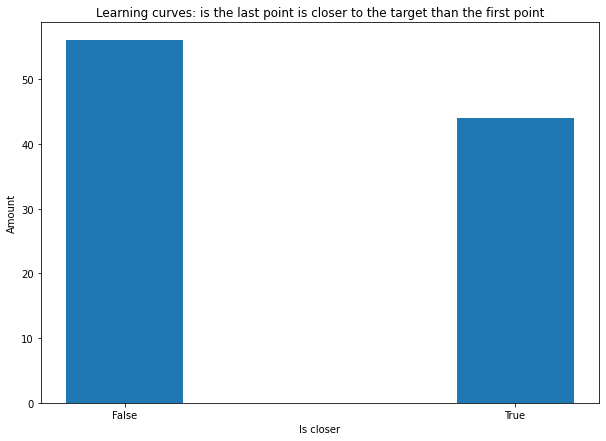

In [7]:
better_arr = np.array((last_rewards[-100:] - first_rewards[-100:])>0, dtype = int)
plt.figure(figsize=(10,7))
better_results = np.sum(better_arr)
plt.bar([0, 1],[len(better_arr)-better_results, better_results], 0.3)
plt.xticks([0,1],labels = ["False", "True"])
plt.title("Learning curves: is the last point is closer to the target than the first point")
plt.ylabel("Amount")
plt.xlabel("Is closer")
plt.savefig("closer_points.png")
plt.show()

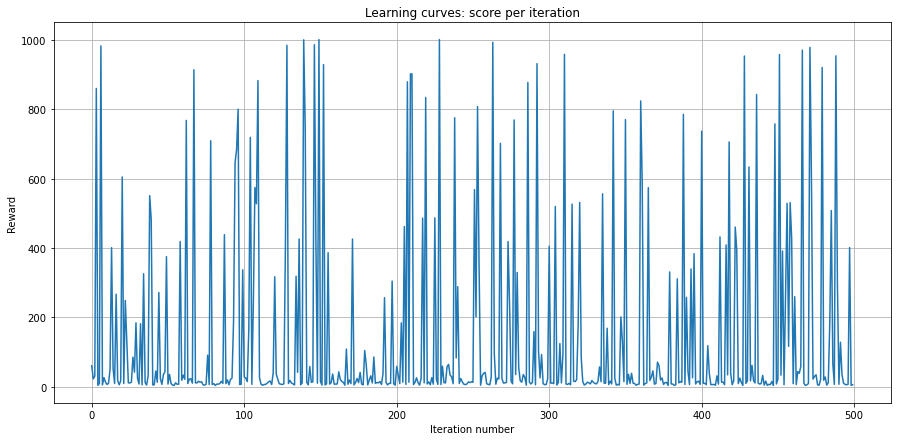

In [8]:
plt.figure(figsize=(15,7))
plt.grid()
x=list(range(len(scores)))
plt.plot(x, scores)

plt.title("Learning curves: score per iteration")
plt.ylabel("Reward")
plt.xlabel("Iteration number")
plt.savefig("learning_curves.png")
plt.show()

In [15]:
for i in range(1,6):
    print(i,"Average learning score on 100 steps: ", np.mean(scores[(i-1)*100: i*100]))

1 Average learning score on 100 steps:  131.38790479130424
2 Average learning score on 100 steps:  134.89579509874565
3 Average learning score on 100 steps:  162.68082655031264
4 Average learning score on 100 steps:  115.6675870243253
5 Average learning score on 100 steps:  170.12385515771396


Average reward on test 100 games:  157.26835837769286


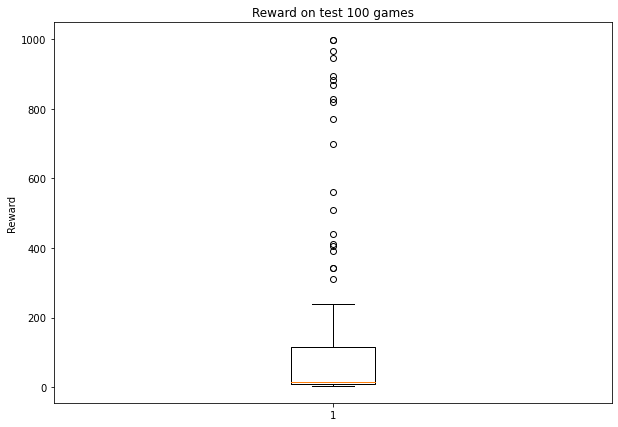

In [9]:
test_games = 100

test_scores = []
test_last_rewards = []
for game_index in range(test_games):
    score = 0
    time_step = env.reset()  
    obs = convert_observation(time_step.observation)
    while not time_step.last(): 
        action = agent.target_actor_model.predict(obs)
        time_step = env.step(action[0])
        obs = convert_observation(time_step.observation)
        score += time_step.reward

    test_scores.append(score)
    test_last_rewards.append(time_step.reward)

print("Average reward on test 100 games: ", np.mean(test_scores))

fig, ax = plt.subplots(figsize=(10,7))
ax.set_title('Reward on test 100 games')
ax.boxplot(test_scores,   
          showfliers=True)

ax.set_ylabel("Reward")
plt.savefig("rewards.png")
plt.show()

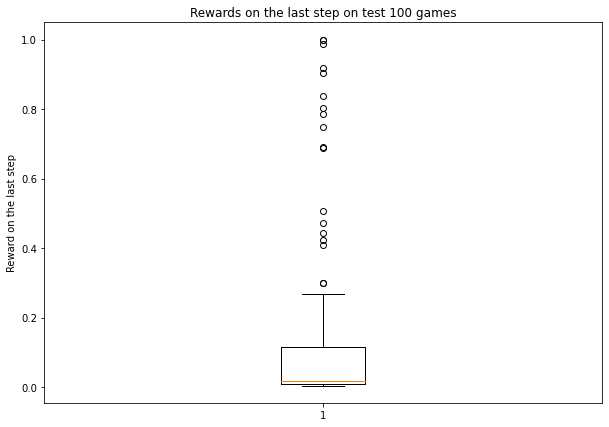

In [10]:
fig, ax = plt.subplots(figsize=(10,7))
ax.set_title('Rewards on the last step on test 100 games')
ax.boxplot(test_last_rewards,   
          showfliers=True)

ax.set_ylabel("Reward on the last step")
plt.savefig("last_rewards.png")
plt.show()